In [2]:
# import utils
import numpy as np
import pandas as pd

# import DEICODE
import qiime2 as q2
from biom import Table, load_table
from qiime2.plugins.deicode.actions import rpca
from skbio import OrdinationResults
from deicode.preprocessing import rclr

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [32]:
# import tables
bt = load_table('data/table.biom')
mf = pd.read_csv('data/metadata.tsv',
                 sep='\t', index_col=0)
mf = mf[mf.age > 12.0]
shared_ = list(set(bt.ids()) & set(mf.index))
mf = mf.reindex(shared_)
bt = bt.filter(shared_)
# check sum
passed_ = bt.ids('observation')[bt.sum('observation') > 0]
bt = bt.filter(passed_, axis='observation')
# filter freq.
freq_ = bt.matrix_data.toarray().astype(bool).sum(1) / bt.shape[1]
freq_tmp = freq_.copy()
freq_ = bt.ids('observation')[freq_ > .001]
bt = bt.filter(freq_, axis='observation')
# get dataframe
btdf = pd.DataFrame(bt.matrix_data.toarray(),
                     bt.ids('observation'),
                     bt.ids())
# check shape
mf.head(5)


,age,age_units,anonymized_name,body_habitat,body_product,body_site,cage_location,cage_number,collection_timestamp,description,...,qiita_empo_3,qiita_study_id,sample_type,scientific_name,sex,taxon_id,title,weekly_cage_food_consumption,weight,weight_units
sample_name,,,,,,,,,,,,,,,,,,,,,
10422.27.F.10,14.5,weeks,27-F-10,UBERON:feces,UBERON:feces,UBERON:feces,On counter,7,2016-03-18 10:00,feces mouse 27 collection 10 of 13,...,Animal distal gut,10422,stool,mouse gut metagenome,male,410661,OSA,Missing: Not provided,28.5,g
10422.31.F.10,14.5,weeks,31-F-10,UBERON:feces,UBERON:feces,UBERON:feces,On counter,8,2016-03-18 10:00,feces mouse 31 collection 10 of 13,...,Animal distal gut,10422,stool,mouse gut metagenome,male,410661,OSA,Missing: Not provided,28.0,g
10422.28.F.9,14.0,weeks,28-F-9,UBERON:feces,UBERON:feces,UBERON:feces,On counter,7,2016-03-15 10:00,feces mouse 28 collection 9 of 13,...,Animal distal gut,10422,stool,mouse gut metagenome,male,410661,OSA,85.9,27.3,g
10422.28.F.12,15.5,weeks,28-F-12,UBERON:feces,UBERON:feces,UBERON:feces,On counter,7,2016-03-25 10:00,feces mouse 28 collection 12 of 13,...,Animal distal gut,10422,stool,mouse gut metagenome,male,410661,OSA,Missing: Not provided,28.2,g
10422.21.F.9,14.0,weeks,21-F-9,UBERON:feces,UBERON:feces,UBERON:feces,In chamber,6,2016-03-15 10:00,feces mouse 21 collection 9 of 13,...,Animal distal gut,10422,stool,mouse gut metagenome,male,410661,OSA,80.9,27.0,g


In [21]:
table_ = q2.Artifact.import_data('FeatureTable[Frequency]',
                                 bt)
# increae rank used
ords_ = {}
prop_ = {}
steps = [2, 4, 10, 20, 50]
for rank_ in steps:
    print(rank_)
    # do dimentionality reductions
    rpca_res = rpca(table_, n_components = rank_)
    rpca_ord = rpca_res.biplot.view(OrdinationResults)
    # save ordination
    ord_df = rpca_ord.samples
    ords_[rank_] =  pd.concat([ord_df, mf.reindex(ord_df.index)],
                              axis=1, sort=False)
    # previous
    prev_frac = rpca_ord.eigvals.values**2 / np.sum(rpca_ord.eigvals.values**2)
    # new prop.
    X_proj = rpca_ord.samples.values * rpca_ord.eigvals.values
    tot_var =  np.nansum(np.nanvar(rclr(btdf.values), axis=1))
    new_frac = np.var(X_proj, axis=0) / tot_var
    # save frac explained
    prop_[rank_] = [prev_frac, new_frac]


2
4
10
20
50


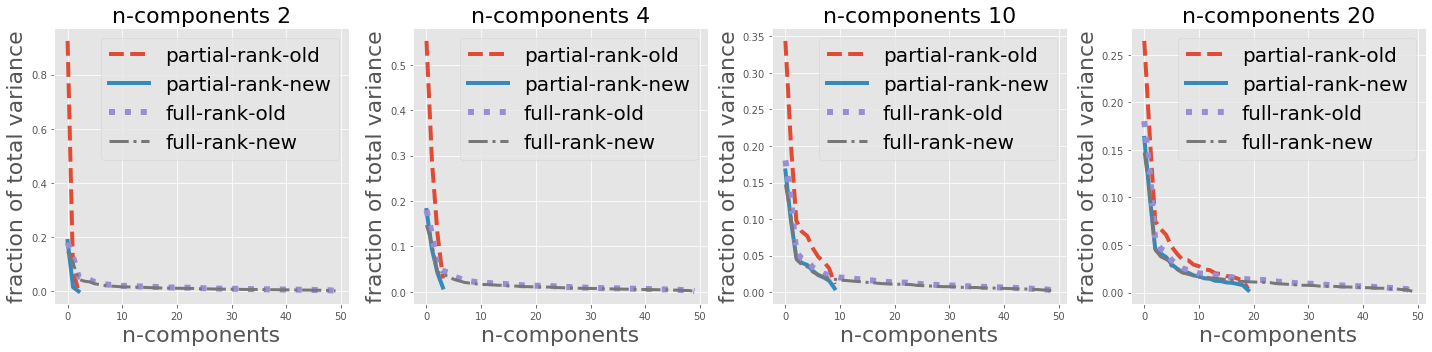

In [22]:
# inspect each model's frac. exp.
n_show = list(range(len(steps[:-1])))  
# figure
fig, axns = plt.subplots(1, len(n_show),
                         figsize=(5*len(n_show),
                                  5))
# plot
for ax, rank_ in zip(axns.flatten(),
                     [steps[i] for i in n_show]):

    ax.plot(prop_[rank_][0], label='partial-rank-old',ls='--', lw=4)
    ax.plot(prop_[rank_][1], label='partial-rank-new',ls='-', lw=4)
    ax.plot(prop_[steps[-1]][0], label='full-rank-old',ls=':', lw=6)
    ax.plot(prop_[steps[-1]][1], label='full-rank-new',ls='-.', lw=3)


    ax.legend(loc='best', prop={'size':20})
    ax.set_xlabel('n-components',
                  fontsize=22)
    ax.set_ylabel('fraction of total variance',
                  fontsize=22)
    title_ = str('n-components %i' % rank_)
    ax.set_title(title_,
                 fontsize=22)

plt.tight_layout()
plt.show()


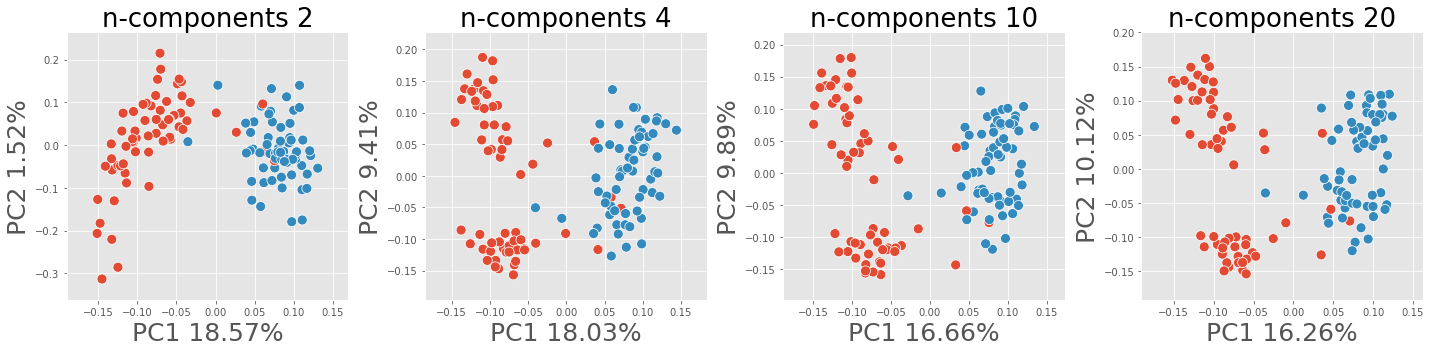

In [23]:
fig, axns = plt.subplots(1, len(n_show),
                         figsize=(5*len(n_show),
                                  5))

for ax, rank_ in zip(axns.flatten(),
                     [steps[i] for i in n_show]):

    sns.scatterplot(x=0, y=1,
                    hue='exposure_type',
                    data=ords_[rank_],
                    ax=ax, s=100)
    ax.legend_.remove()

    pc1_label = 'PC1 %.2f%%' % (prop_[rank_][1][0] * 100)
    pc2_label = 'PC2 %.2f%%' % (prop_[rank_][1][1] * 100)
    ax.set_xlabel(pc1_label,
                  fontsize=25)
    ax.set_ylabel(pc2_label,
                  fontsize=25)
    title_ = str('n-components %i' % rank_)
    ax.set_title(title_,
                 fontsize=26)
plt.tight_layout()
plt.show()